## Buoyant cloud initial conditions 
For the [**Magnetic-Coriolis (MC) wave project**](https://github.com/benmcdermott/MCwave)
 
We initialise our numerical simulations (see simsetup.txt for simulation details) with a localised layer of buoyant anomalies in the vertical centre of the simulation box. Each one of the buoyant anomalies is spherical and has a Gaussian radial profile $\rho^{\prime} \sim \exp [-(\boldsymbol{x}-\boldsymbol{x}_i)^2/\delta_i^2]$, where $\boldsymbol{x}_i$ locates the blob centre and $\delta_i$ is the blob size. The blob sizes are sampled from a uniform distribution about the mean blob size $\delta$ such that $\delta/2 \leq \delta_i \leq 3\delta/2$. We restrict the blob centres $\boldsymbol{x}_i$ to the layer $-2 \delta \leq z \leq 2 \delta$, and the fill the box in the plane normal to $\boldsymbol{e}_z$. We compute $b=g\rho^{\prime}/\rho$ (units of acceleration) and output Fortran ordered binary files for input to the code.

Initial velocity and magnetic fields are zero, the buoyancy field is the source of energy for the waves.

**First import modules needed to generate initial fields**

In [51]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import ticker

%matplotlib inline
rc('text', usetex=True)
rc('axes', linewidth=1.5)
rc('lines', linewidth=2.0)
rc('xtick.major', size=5)
rc('xtick.major', width=1.5)
rc('ytick.major', size=5)
rc('ytick.major', width=1.5)
#plt.style.use('benmc')
path = '/home/brm35/PycharmProjects/MCwave/'

**Spatial resolution, grid and number of blobs**

In [3]:
nx = 256                                        # points in (x,y)
nz = nx                                         # points in z
nb = 1000                                       # number of blobs
delta = 0.125                                   # blob size
gvx = np.linspace(-np.pi,np.pi,nx)              # grid vectors in (x,y) and z
gvz = np.linspace(-3.0*np.pi,3.0*np.pi,nz)
[X,Y,Z] = np.meshgrid(gvx,gvx,gvz)              # 3D grid

**Sum random perturbations from $\texttt{nb}$ blobs**

In [4]:
def gauss_blob(r,d):
# note r is the position vector squared
    return np.exp(-r/(d*d))

b = np.zeros(np.shape(X))
d = np.zeros((nb,1)) ; x= np.zeros((nb,1)) ; y = np.zeros((nb,1)) ; z = np.zeros((nb,1)) ;
for i in range(nb):
    d[i] = 0.5*delta + 0.5*delta*random.uniform(0,1)         # blob size
    x[i] = -np.pi + 2.0*np.pi*random.uniform(0,1)            # x position
    y[i] = -np.pi + 2.0*np.pi*random.uniform(0,1)            # y position
    z[i] = -2.0*delta + 4.0*delta*random.uniform(0,1)        # z position
    r = (X-x[i])**2 + (Y-y[i])**2 + (Z-z[i])**2              # squared position
    b = b + gauss_blob(r,d[i])                               # sum random blobs

**Plot buoyancy field in the mid-plane of the box**

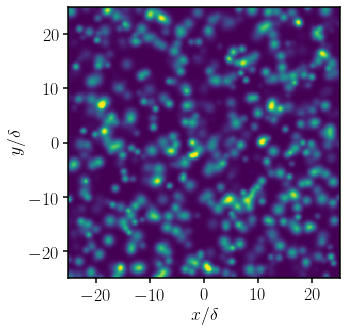

In [61]:
i_mid =int(nz/2-1)              # index for middle slice
b0 = b[:,:,i_mid]               # middle slice

# plotting 
plt.figure(figsize=[6,5])
p = plt.pcolor(X[:,:,i_mid]/delta, Y[:,:,i_mid]/delta, b0)
ax = plt.gca() ;
plt.xlabel(r'$x/\delta$', fontsize=18) ;
plt.ylabel(r'$y/\delta$', fontsize=18) ;
plt.setp(ax.get_xticklabels(), fontsize=18) ;
plt.setp(ax.get_yticklabels(), fontsize=18) ;
ax.set_xlim([-np.pi/delta,np.pi/delta]) ;
ax.set_ylim([-np.pi/delta,np.pi/delta]) ;
ax.axis('square')
plt.clim(0.0,0.75*np.max(b0[:]))
plt.savefig(path+'cloud_ic_midplane.png', dpi=600, bbox_inches='tight')

**Histograms of blob positions and sizes**

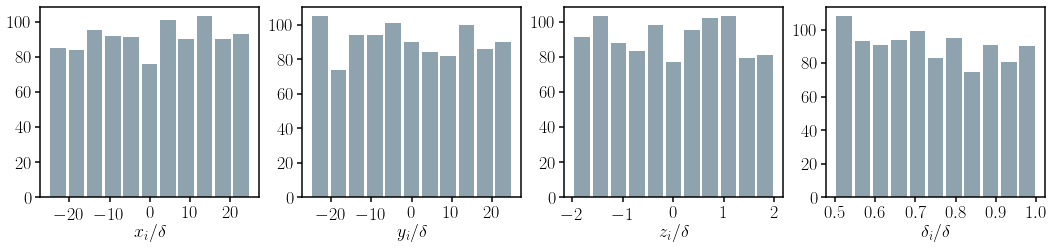

In [62]:
plt.figure(figsize=[18,3.5])
plt.subplot(1,4,1)
plt.hist(x/delta, bins='auto', color='#607c8e',alpha=0.7, rwidth=0.85)
plt.xlabel(r'$x_i/\delta$', fontsize=18) ;
ax=plt.gca()
plt.setp(ax.get_xticklabels(), fontsize=18) ;
plt.setp(ax.get_yticklabels(), fontsize=18) ;

plt.subplot(1,4,2)
plt.hist(y/delta, bins='auto', color='#607c8e',alpha=0.7, rwidth=0.85)
plt.xlabel(r'$y_i/\delta$', fontsize=18) ;
ax=plt.gca()
plt.setp(ax.get_xticklabels(), fontsize=18) ;
plt.setp(ax.get_yticklabels(), fontsize=18) ;

plt.subplot(1,4,3)
plt.hist(z/delta, bins='auto', color='#607c8e',alpha=0.7, rwidth=0.85)
plt.xlabel(r'$z_i/\delta$', fontsize=18) ;
ax=plt.gca()
plt.setp(ax.get_xticklabels(), fontsize=18) ;
plt.setp(ax.get_yticklabels(), fontsize=18) ;

plt.subplot(1,4,4)
plt.hist(d/delta, bins='auto', color='#607c8e',alpha=0.7, rwidth=0.85)
plt.xlabel(r'$\delta_i/\delta$', fontsize=18) ;
ax=plt.gca()
plt.setp(ax.get_xticklabels(), fontsize=18) ;
plt.setp(ax.get_yticklabels(), fontsize=18) ;

plt.savefig(path+'cloud_ic_hists.pdf', dpi=600, bbox_inches='tight')

**Fill fraction** : volume of blobs / volume of layer (~50 % is OK)

In [7]:
V_blobs = np.sum((4.0/3.0)*np.pi*(d/2)**2)
V_layer = 4.0*delta*(2.0*np.pi)**2
fill_fraction = V_blobs / V_layer
print(f'Fill fraction: {100.0*fill_fraction} %')


Fill fraction: 47.38946117105362 %


**Horizontal spatial spectrum of mid-plane buoyancy**

In [22]:
# function to compute 2D isotropic spectra in a plane
def scalar_spec2d(s,nx):
    factor = 1.0/nx/nx                                  # fft normalisation factor
    ind = int(nx/2)
    dk = 1.0
    k = np.arange(0.0,nx/2-1+dk,1.0)                         # positive horizontal wavenumbers
    s_hat = np.fft.fft2(s)                              # 2D fft
    s_hat = factor*s_hat[0:ind,0:ind]                   # normalise and cut
    
    kmag = np.zeros((ind,ind))
    E = np.zeros((ind,ind))
    for i in range(ind):
        for j in range(ind):
            kmag[i,j] = np.sqrt(k[i]**2 + k[j]**2)
            E[i,j] = np.pi*kmag[i,j]*s_hat[i,j]*np.conj(s_hat[i,j])
    
    # sort E by increasing order of k
    kflat = np.ndarray.flatten(kmag)
    Eflat = np.ndarray.flatten(np.real(E))
    isort = np.argsort(kflat)
    ksort = kflat[isort]
    Esort = Eflat[isort]
    
    # form spectrum as a function of k_perp by binning Esort into rings of width dk=1
    spec = np.zeros((ind,1))
    for i in range(ind):
        for j in range(ind**2):
            if ksort[j] >= k[i]:
                if ksort[j] < k[i]+dk:
                    spec[i] += Esort[j]
    
    return k, spec

k, spec = scalar_spec2d(b0,nx)

/home/brm35/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


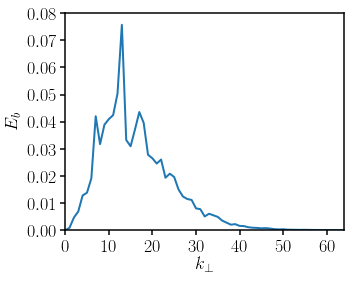

In [63]:
plt.figure(figsize=[5,4])
plt.plot(k,spec)
ax=plt.gca()
plt.xlabel(r'$k_{\perp}$', fontsize=18) ;
plt.ylabel(r'$E_b$', fontsize=18) ;
plt.setp(ax.get_xticklabels(), fontsize=18) ;
plt.setp(ax.get_yticklabels(), fontsize=18) ;
ax.set_xlim([0,nx/4]) ;
ax.set_ylim([0,0.08]) ;
plt.savefig(path+'cloud_ic_spec.pdf', dpi=600, bbox_inches='tight')